Notebook adapted from Zoe Ashwood

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [5]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sglm import hmmUtils, utils
import ssm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
train_split = 0.80
seed = np.random.randint(1000)
print(seed)

708


#### 1a. Import your data

In [105]:
import sys
sys.path.append(f'{os.path.expanduser("~")}/GitHub/behavior-helpers/')
sys.path.append(f'{os.path.expanduser("~")}/GitHub/neural-timeseries-analysis/')

from bh.data.datasets import HFTrials
from bh.models.glmhmm import GLMHMM

data = HFTrials(mice='C37', verbose=False)


C37: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


In [212]:
sticky = GLMHMM(num_states=[1, 2, 3, 4], prior_sigma=2, prior_alpha=2)

In [213]:
sticky.prepare_features(data.trials.copy(), 'direction')
sticky.split_data(ptrain=train_split, verbose=True)

[1. 0.]
[ 1. -1.]
[ 1.  0. -1.]
13 training sessions and 4 test sessions


Input-Driven Observations: This means that the observations you see (e.g., the weather you observe) are influenced by some external factors or covariates. For example, the probability of observing rain on a particular day might be influenced by the temperature or humidity on that day.

Input-Driven Transitions: This means that the transition probabilities between different hidden states (e.g., different weather patterns) are influenced by external factors. For example, the likelihood of transitioning from a sunny day to a rainy day might depend on some external factors.

Stationary Transitions: On the other hand, "stationary transitions" mean that the transitions between hidden states are fixed and do not depend on external inputs. In the context of the weather, this would mean that the probability of transitioning from one weather pattern to another is constant and doesn't change based on external factors.

### 2a. Data and param set up

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Model with 0 states:
     train LL = 0.00
     test LL  = 0.00
Model with 1 states:
     train LL = 0.00
     test LL  = 0.00
Model with 2 states:
     train LL = 0.00
     test LL  = 0.00
Model with 3 states:
     train LL = -0.25
     test LL  = -0.28


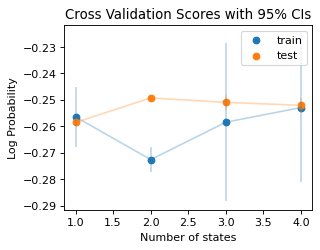

In [214]:
sticky.init_model(transitions='sticky',
                  transition_kwargs={'alpha': sticky.prior_alpha, 'kappa': 0})
lls, scores = sticky.fit_cv()
sticky.compare_k_states(scores)
LL = sticky.calc_log_likelihood(verbose=False)
LL_norm = sticky.calc_log_likelihood(verbose=True, normalize=True)

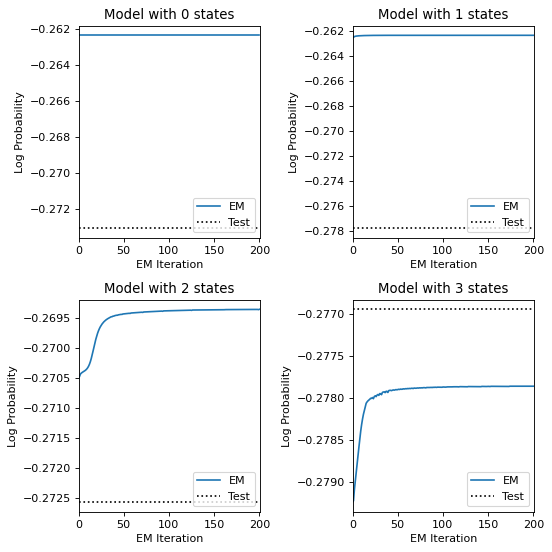

In [215]:
## Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(7, 7), dpi=80,)
for i, (ax, ll) in enumerate(zip(axs.ravel(), lls)):
    ll = np.array(ll) / sticky.train_num_trials
    ax.plot(ll, label="EM")
    ax.plot([0, len(ll)], LL_norm['test'][i] * np.ones(2), ':k', label="Test")
    ax.legend(loc="lower right")
    ax.set(xlabel="EM Iteration", xlim=(0, len(ll)), ylabel="Log Probability",
           title=f'Model with {i} states')
plt.tight_layout()

In [216]:
bits = sticky.calc_log_likelihood(verbose=True, as_bits=True)

Model with 0 states:
     train LL = 0.00
     test LL  = 0.00
Model with 1 states:
     train LL = 0.00
     test LL  = 0.00
Model with 2 states:
     train LL = 0.00
     test LL  = 0.00
Model with 3 states:
     train LL = 0.64
     test LL  = 0.60


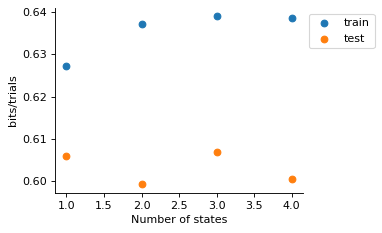

In [217]:
sticky.compare_k_states_no_err(bits, ylab='bits/trials')

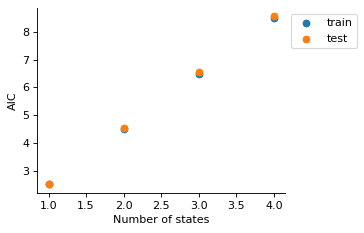

In [218]:
aic = sticky.calc_aic(LL)
sticky.compare_k_states_no_err(aic, ylab='AIC')

In [303]:
sticky.predict_state()
acc = sticky.predict_choice(accuracy=True, verbose=True)

Model with 0 state(s) has a test predictive accuracy of 0.8967576791808873
Model with 1 state(s) has a test predictive accuracy of 0.8890784982935154
Model with 2 state(s) has a test predictive accuracy of 0.886518771331058
Model with 3 state(s) has a test predictive accuracy of 0.8848122866894198


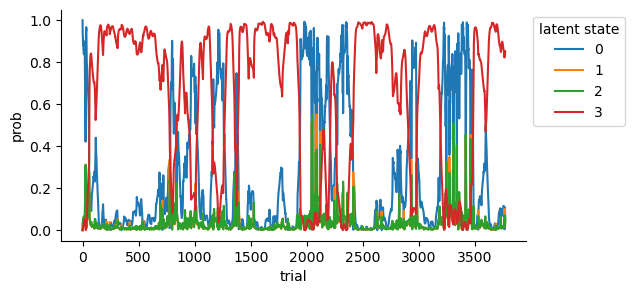

In [318]:
sticky.plot_state_probs(3)

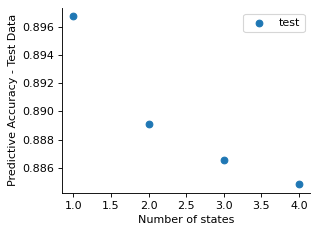

In [302]:
sticky.compare_k_states_no_err({'test': acc}, datasets=['test'], ylab='Predictive Accuracy - Test Data')

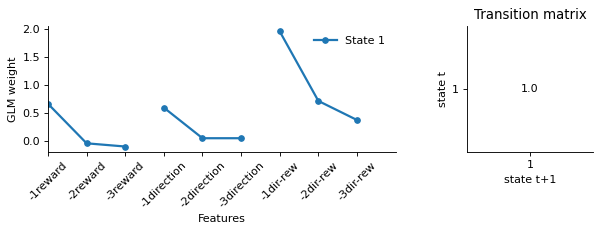

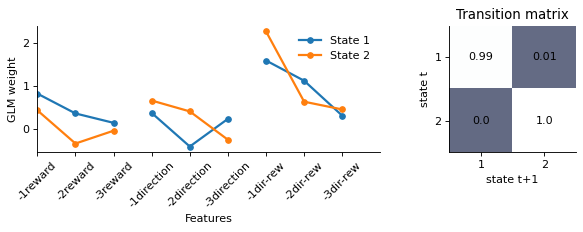

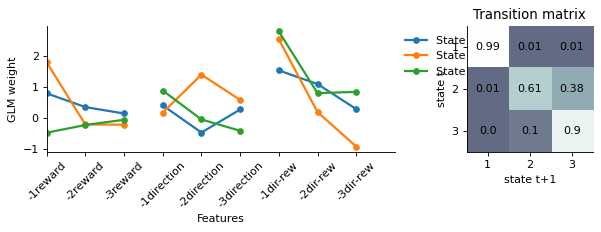

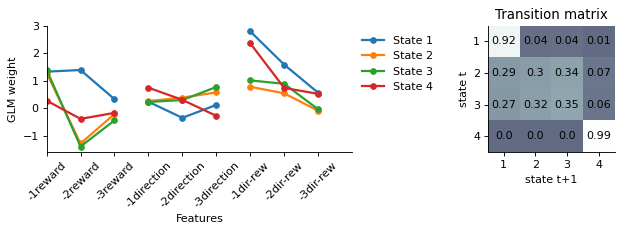

In [367]:
for i in range(4):
    sticky.plot_glm_weights(i)

In [ ]:
#Loop through all models to get posterior probabilities for train data and state_occupancies
posterior_probs_list = []
state_occupancies_list = []
for i in range(len(num_states)):
    posterior_probs = [sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]
    posterior_probs_concat = np.concatenate(posterior_probs)
    state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    _, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)
    posterior_probs_list.append(posterior_probs)
    state_occupancies_list.append(state_occupancies)

#Loop through all models to get posterior probabilities for test data and state_occupancies
sticky_test_posterior_probs_list = []
sticky_test_state_occupancies_list = []
for i in range(len(num_states)):
    sticky_test_posterior_probs = [sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])]
    sticky_test_posterior_probs_concat = np.concatenate(sticky_test_posterior_probs)
    sticky_test_state_max_posterior = np.argmax(sticky_test_posterior_probs_concat, axis = 1)
    _, sticky_test_state_occupancies = np.unique(sticky_test_state_max_posterior, return_counts=True)
    sticky_test_state_occupancies = sticky_test_state_occupancies/np.sum(sticky_test_state_occupancies)
    sticky_test_posterior_probs_list.append(sticky_test_posterior_probs)
    sticky_test_state_occupancies_list.append(sticky_test_state_occupancies)

In [ ]:
trials_to_plot = (0, 500) # number of trials to plot
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')

for k in range(num_states_2plot):
    posterior_probs = posterior_probs_list[model_to_plot]
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)
plt.title('Sticky HMM')

In [ ]:
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(sticky_test_state_occupancies_list[model_to_plot]):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks(range(num_states_2plot), range(num_states_2plot), fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)
plt.title('Sticky HMM')

### 2b. Option 2 -- Stationary HMM -- input driven, looping through states. Much the same as above except, we are changing the transitions to 'standard'.

In [11]:
stationary_model_list = []
stationary_ll_list = []
stationary_train_scores = []
stationary_test_scores = []
for i in range(len(num_states)):
    from ssm import model_selection
    map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
                transitions="standard")
    train_scores, test_scores = ssm.model_selection.cross_val_scores(map_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=5, verbose=True)
    N_iters = 200
    stationary_ll = map_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize=False)
    stationary_ll_list.append(stationary_ll)
    stationary_train_scores.append(train_scores)
    stationary_test_scores.append(test_scores)
    stationary_model_list.append(map_glmhmm)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'input_dim': input_dim,
                'num_categories': num_categories,
                'input_dim': input_dim,
                'C': C,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': "input_driven_obs",
                'x_cols': x_cols,
                'notes': "used 3 nback data, 80-20 prob, 80-20 split, 4 states, reward is 0-1, choice is -1-1, interaction is product of reward and choice"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids}

#create dictionary for pickle
stationary_dict = {'model_params' : model_params,
                    'data_splits': data_splits,
                   'stationary_model_list': stationary_model_list,
                   'stationary_train_scores': stationary_train_scores,
                   'stationary_test_scores': stationary_test_scores,
                   'stationary_ll_list': stationary_ll_list}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data'
pickle.dump(stationary_dict, open(os.path.join(save_dir, 'stationary_3nback_80-20_80-20split.pkl'), 'wb'))

In [ ]:
#load model list, train and test scores, and LL list
import pickle
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data'

stationary_dict = pickle.load(open(os.path.join(save_dir, 'stationary_3nback_80-20_Reward_neg.pkl'), 'rb'))
model_params = stationary_dict['model_params']
stationary_model_list = stationary_dict['stationary_model_list']
stationary_train_scores = stationary_dict['stationary_train_scores']
stationary_test_scores = stationary_dict['stationary_test_scores']
stationary_ll_list = stationary_dict['stationary_ll_list']


In [ ]:
num_states = model_params['num_states']
obs_dim = model_params['obs_dim']
input_dim = model_params['input_dim']
num_categories = model_params['num_categories']
input_dim = model_params['input_dim']
C = model_params['C']
prior_sigma = model_params['prior_sigma']
prior_alpha = model_params['prior_alpha']
observations = model_params['observations']
notes = model_params['notes']

In [ ]:
# Plot stationary train/test scores with CIs
# Calculate train/test likelihoods
# Normalize LLs
# Plot EM learning curves by state
# calculate bits by state
# calculate AIC
# calculate prob for each state across trials (expectations)
# predict choice and calculate accuracy

In [33]:
#Loop through all models to get posterior probabilities for train data and state_occupancies
posterior_probs_list = []
state_occupancies_list = []
for i in range(len(num_states)):
    posterior_probs = [stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]
    posterior_probs_concat = np.concatenate(posterior_probs)
    state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    _, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)
    posterior_probs_list.append(posterior_probs)
    state_occupancies_list.append(state_occupancies)

#Loop through all models to get posterior probabilities for test data and state_occupancies
stationary_test_posterior_probs_list = []
stationary_test_state_occupancies_list = []
for i in range(len(num_states)):
    stationary_test_posterior_probs = [stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])]
    stationary_test_posterior_probs_concat = np.concatenate(stationary_test_posterior_probs)
    stationary_test_state_max_posterior = np.argmax(stationary_test_posterior_probs_concat, axis = 1)
    _, stationary_test_state_occupancies = np.unique(stationary_test_state_max_posterior, return_counts=True)
    stationary_test_state_occupancies = stationary_test_state_occupancies/np.sum(stationary_test_state_occupancies)
    stationary_test_posterior_probs_list.append(stationary_test_posterior_probs)
    stationary_test_state_occupancies_list.append(stationary_test_state_occupancies)

Text(0.5, 1.0, 'Standard HMM')

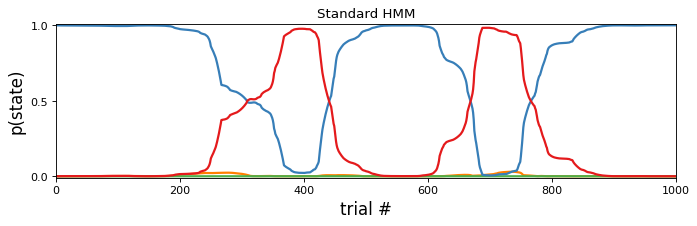

In [35]:
trials_to_plot = (0, 1000) # number of trials to plot
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')

for k in range(num_states_2plot):
    posterior_probs = posterior_probs_list[model_to_plot]
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)
plt.title('Standard HMM')

Text(0.5, 1.0, 'Standard HMM')

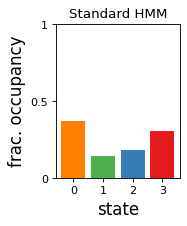

In [36]:
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(stationary_test_state_occupancies_list[model_to_plot]):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks(range(num_states_2plot), range(num_states_2plot), fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)
plt.title('Standard HMM')

Text(0.5, 1.0, 'Generative transition matrix - Standard')

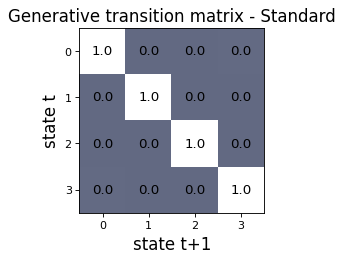

In [37]:
#plot transition matrix
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

gen_weights = stationary_model_list[model_to_plot].observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = stationary_model_list[model_to_plot].transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.yticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix - Standard", fontsize = 15)

## 3. We've been looping through a list of states, but we can also just select a single state and run the model on it

### 3a. Fit GLM-HMM and perform recovery analysis -- this should come after the model selection section above

In [ ]:
# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()

# Model Inputs
num_states = 3 # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [ ]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard") # transitions usually standard


In [ ]:
## perform cross-validation
from ssm import model_selection
test_scores, train_scores = ssm.model_selection.cross_val_scores(new_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=5, verbose=True)

In [ ]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(choices, inputs=inpts, method='em', num_iters=N_iters, tolerance=10**-4) #method="em",
print("EM converged: ", fit_ll)

In [ ]:
#fit to test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()

test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts)
print("Test LL: ", test_ll)

In [ ]:
#normalize the log likelihood
norm_ll = [s / num_trials_per_train_sess for s in fit_ll if s is not None]
norm_test = test_ll / num_trials_per_test_sess

In [ ]:
# Plot the log probabilities of the train and test models. Fit model final LL should be greater 
# than or equal to true LL.

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(norm_ll, label="EM")
plt.plot([0, len(norm_ll)], norm_test * np.ones(2), ':k', label="Test")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [ ]:
T = inpts.shape[0] # number of trials
K = 2 # number of latent states
C = 2 # number of observation classes or # C represents the binary choice the animal must make
D = inpts.shape[1] # number of GLM inputs (regressors)

# # Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]

In [ ]:
trials_to_plot = (0, 300) # number of trials to plot

cols = ['#ff7f00', '#4daf4a', '#377eb8']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)

In [ ]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

In [ ]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [ ]:
model_gen_weights = new_glmhmm.observations.params

#Plot the weights for each input regressor against each state
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(model_gen_weights[k,0,:], label="State " + str(k + 1), lw=2,
             color=cols[k], marker = 'o', markersize = 5)
plt.legend(loc="lower right")
plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
plt.ylabel("GLM weight", fontsize = 15)
plt.xlabel("Inputs", fontsize = 15)
plt.xlim((0, len(x_cols)))


In [ ]:
num_states_2plot = num_states
gen_weights = new_glmhmm.observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = new_glmhmm.transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.yticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [ ]:
train_data.loc[:, 'State_Occupancy'] = state_max_posterior # State_Max_Posterior contains the state for each given trial 

#save new csv
#filtered_data.to_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FullMerged_2nBack_100423.csv', index=True)